## **0 - Introduction and Install Dependencies** (_if needed_)

**NOTE**: This notebook is purely for playing around with potential models/hyperparameters. This notebook is _not_ meant to train the entire model itself. We use the train.py files to train fully as it allows more sophisticated usage of command line when training the models to specify certain hyperparameters.

If you are seeing this notebook for the first time and would like to run it, please follow these steps. Note that you will need several (>9) GB of free space in order to succesfully do the following:

1) In the same directory where this notebook is currently located on your device, make a new folder called "data\".
2) Visit this [page on Kaggle](https://www.kaggle.com/datasets/grassknoted/asl-alphabet) and download the dataset.
3) Extract the data from the compressed file into the "data\" folder, such that your current directory mirrors the following (thank you for helping me generate this figure ChatGPT):

```
root_directory
   |- exploratory_analysis.ipynb
   |- data
      |- asl_alphabet_test
         |- data...
      |- asl_alphabet_train
         |- data...
```

In [39]:
#%pip install -U argparse
#%pip install -U tqdm
#%pip install -U scikit-learn
#%pip install -U opencv-python
#%pip install -U matplotlib
#%pip install -U tensorflow
#%pip install -U pandas
#%pip install -U numpy

## **1 - Load Libraries**

In [40]:
# Load dependencies
from keras.layers import Conv2D, Dense, Dropout, Flatten # type: ignore
from keras.models import Sequential # type: ignore
import tensorflow as tf # type: ignore
import os
import argparse
from keras.models import Sequential, Model # type: ignore
import numpy as np # type: ignore
from numpy.random import seed # type: ignore
import cv2 # type: ignore
import matplotlib.pyplot as plt # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from tqdm import tqdm # type: ignore
import pandas as pd # type: ignore
import math
import random
import tensorflow_addons as tfa # type: ignore
seed(42)

## **2 - Transforms**

We specify a number of transformations we can apply to our image data. Obviously many kinds of transforms don't necessarily need to be applied to our validation Data. We add more the training data to make it more robust. 

In [41]:
# Transforms for tf.data.Dataset inspired by: https://stackoverflow.com/questions/58270150/is-there-some-simple-way-to-apply-image-preprocess-to-tf-data-dataset
def transformTrainData(image, label):
    '''
    See the documentation for tf.image for more information on the transformations: 
    https://www.tensorflow.org/api_docs/python/tf/image
    '''
    # Performs scaling. NOTE: FEEL FREE TO MODIFY. SEE DOCUMENTATION ABOVE TO FIND MORE TRANSFORMATIONS.
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.rot90(image, k = random.randint(0, 3))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

def transformValData(image, label):
    '''
    See the documentation for tf.image for more information on the transformations:
    https://www.tensorflow.org/api_docs/python/tf/image
    '''
    # Performs scaling
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

## **3 - Hyperparamters** (_feel free to adjust_)

We specify hyperparameters to test our model on. We choose which model to use later on. Feel free to experiment with different hyperparameters. 

In [42]:
# Specify a splitting for our train, val, and test data, and other hyperparameters
val_split = 0.2
# Image size
img_size = 64
# Batch size. This is the number of images that will be fed into the model at once. Adjust based on your memory capacity.
batch_size = 32
# Color mode
color = 'rgb' # 'grayscale'
# Seed for reproducibility
seed = 42
# Number of epochs
epochs = 5
# Loss function
loss = 'categorical_crossentropy'#'sparse_categorical_crossentropy' # 'categorical_crossentropy' (one-hot encoded labels) or 'sparse_categorical_crossentropy' (integer labels
# Optimizer
optimizer = 'adam' # 'sgd'
# Regularization parameters
wd = None
# momentum is a hyperparameter for the optimizer SGD that helps accelerate the convergence of the model
momentum = 9e-06
# learning rate is a hyperparameter that controls how much we are adjusting the weights of our network with respect the loss gradient
lr = 0.001
# Apply softmax to the output layer?
from_logits = False
# Metrics to track
metrics = ['accuracy'] # 'accuracy', 'f1_score', 'precision', 'recall'
# number of classes
num_classes = 29

## **4 - Preprocessing**

In [43]:
# The data directories
data_path = "./data/asl_alphabet_train/asl_alphabet_train/"
test_path = "./data/asl_alphabet_test/asl_alphabet_test/"

In [44]:
# Load the data into a tf.data.Dataset
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(data_path, 
                                                                         labels = 'inferred', 
                                                                         label_mode = 'int' if loss == 'sparse_categorical_crossentropy' else 'categorical', 
                                                                         color_mode = color, 
                                                                         batch_size = batch_size, 
                                                                         image_size = (img_size, img_size), 
                                                                         shuffle = True, 
                                                                         interpolation = 'nearest',
                                                                         seed = seed, 
                                                                         validation_split = val_split, 
                                                                         subset = "both")

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Using 17400 files for validation.


In [45]:
# Map the transformations to the dataset
train_dataset = train_dataset.map(transformTrainData)
val_dataset = val_dataset.map(transformValData)

# **5 - Other utilities**

In [46]:
def optimizerFactory(optim: str, lr: float, momentum: float, wd: float):
    '''
    Choose an optimizer based on the passed in string.
    '''
    if optim == 'sgd':
        return tf.keras.optimizers.SGD(learning_rate = lr, momentum = momentum, decay = wd)
    elif optim == 'adam':
        return tf.keras.optimizers.Adam(learning_rate = lr)
    else:
        raise NotImplementedError(f'Optimizer {optim} not implemented')

In [47]:
def lossFactory(loss: str, from_logits: bool = False):
    if loss == 'sparse_categorical_crossentropy':
        return tf.keras.losses.SparseCategoricalCrossentropy(from_logits = from_logits)
    elif loss == 'categorical_crossentropy':
        return tf.keras.losses.CategoricalCrossentropy(from_logits = from_logits)
    else:
        raise NotImplementedError(f'Loss {loss} not implemented')

## **6 - Training**

We specify metrics we want to track with training. Feel free to add or remove as you please. It seems that some of these metrics will not work when using sparse_categorical_crossentropy as our loss (all except accuracy). 

In [48]:
metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes = 29, average='macro')]

We specify which model we want to train with. Feel free to change to any of the imported models below.

In [49]:
from model.simpleModel import ConvNet3, ConvNet4, ConvNet2
from model.ResNet import ResNet50
from tensorflow.keras.layers import Activation, MaxPooling2D, Flatten, Dense # type: ignore
#model = ConvNet2(img_size, num_classes)
model = ConvNet3(img_size, num_classes)
#model = ConvNet4(img_size, num_classes)
#model = ResNet50(img_size, color, num_classes)

model = Sequential()

model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(29, activation='softmax'))

In [50]:
# We specify our optimizer and loss function, and compile the model with the metrics we want to track
optimizer = optimizerFactory(optimizer, lr, momentum, wd)
loss = lossFactory(loss, from_logits)
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

In [51]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

## **WARNING - run this next cell with a GPU!**

In [52]:
history = model.fit(train_dataset, validation_data = val_dataset, epochs = epochs, shuffle=True)

Epoch 1/5
2175/2175 [==============================] - 66s 30ms/step - loss: 1.5378 - categorical_accuracy: 0.5229 - val_loss: 0.6044 - val_categorical_accuracy: 0.7957
Epoch 2/5
2175/2175 [==============================] - 60s 28ms/step - loss: 0.4261 - categorical_accuracy: 0.8576 - val_loss: 0.2661 - val_categorical_accuracy: 0.9057
Epoch 3/5
2175/2175 [==============================] - 61s 28ms/step - loss: 0.2387 - categorical_accuracy: 0.9195 - val_loss: 0.1922 - val_categorical_accuracy: 0.9349
Epoch 4/5
2175/2175 [==============================] - 63s 29ms/step - loss: 0.1624 - categorical_accuracy: 0.9451 - val_loss: 0.2041 - val_categorical_accuracy: 0.9294
Epoch 5/5
2175/2175 [==============================] - 68s 31ms/step - loss: 0.1277 - categorical_accuracy: 0.9577 - val_loss: 0.0875 - val_categorical_accuracy: 0.9727


In [53]:
#image = cv2.imread('./data/asl_alphabet_train/asl_alphabet_train/A/A100.jpg')
# get an image from val_dataset
images, labels = next(iter(val_dataset))

In [68]:
idx = 29

# get the first image
image = images[idx]

# get the label
label = labels[idx]

# get the prediction
prediction = model.predict(np.expand_dims(image, axis = 0))

# get the predicted class
predicted_class = np.argmax(prediction)

print(f'Predicted class: {predicted_class}')
print(f'Actual class: {np.argmax(label)}')

1/1 [==============================] - 0s 23ms/step
Predicted class: 6
Actual class: 6


1/1 [==============================] - 0s 38ms/step
Predicted class: 19


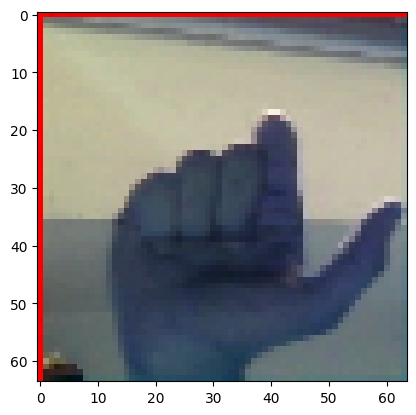

In [80]:
test_img = cv2.imread('./data/asl_alphabet_test/asl_alphabet_test/T_test.jpg')

# resize and apply transforms
test_img = cv2.resize(test_img, (64, 64), interpolation = cv2.INTER_NEAREST)
test_img = tf.image.convert_image_dtype(test_img, tf.float32)
test_img = np.expand_dims(test_img, axis = 0)

# get the prediction
prediction = model.predict(test_img)

# get the predicted class
predicted_class = np.argmax(prediction)

print(f'Predicted class: {predicted_class}')
plt.imshow(test_img.squeeze())